# Estimating causal effect of text features on usefulness

In [1]:
import itertools
import outcome_models
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from patsy import dmatrices
from result_help_functions import Data
from scipy import stats
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

plt.rcParams['font.family'] = 'Times New Roman'

## Read data

In [2]:
filename = 'saved_data/features_interpretable.csv'

df = pd.read_csv(filename)

df = df.dropna(axis=0)
df.reset_index(inplace=True, drop=True)

df.head()

,test,Z1,Z2,Z3,is_positive_sentiment,sentiment_certainty,stars,n_words,n_fans,n_reviews,useful,useful_discrete
0,1,0,0,0,1.0,0.999428,5,176,0,3,0,0
1,1,1,0,1,0.0,0.990075,4,940,330,1224,39,1
2,1,0,0,0,1.0,0.935575,4,131,113,1864,1,1
3,0,0,1,0,0.0,0.999454,1,18,0,6,0,0
4,1,0,1,0,1.0,0.999430,5,63,0,15,0,0


In [3]:
# Define treatments and confounders

treatments = [c for c in df if c.startswith('Z')]

confounders_cont = ['n_words', 'n_fans', 'n_reviews']
confounders_cat = ['stars', 'is_positive_sentiment']

## Look at the data

In [4]:
# Which are the average values in each treatment group?

n_treatments = len(treatments)

if n_treatments == 2:
    for Z1, Z2 in list(itertools.product([0, 1], repeat=2)):
        print('Z1 = ' + str(Z1) + ', Z2 = ' + str(Z2))
        print(df.loc[(df['Z1'] == Z1) & (df['Z2'] == Z2)].mean())
        print()
elif n_treatments == 3:
    for Z1, Z2, Z3 in list(itertools.product([0, 1], repeat=3)):
        print('Z1 = ' + str(Z1) + ', Z2 = ' + str(Z2) + ', Z3 = ' + str(Z3))
        print(df.loc[(df['Z1'] == Z1) & (df['Z2'] == Z2) & (df['Z3'] == Z3)].mean())
        print()
else:
    print('There is no code for ' + str(n_treatments) + ' treatments.')

Z1 = 0, Z2 = 0, Z3 = 0
test                       0.844238
Z1                         0.000000
Z2                         0.000000
Z3                         0.000000
is_positive_sentiment      0.614746
sentiment_certainty        0.965584
stars                      3.678512
n_words                  145.813019
n_fans                    17.327134
n_reviews                189.905679
useful                     1.389572
useful_discrete            0.513119
dtype: float64

Z1 = 0, Z2 = 0, Z3 = 1
test                       0.795000
Z1                         0.000000
Z2                         0.000000
Z3                         1.000000
is_positive_sentiment      0.695000
sentiment_certainty        0.938026
stars                      4.140000
n_words                  341.155000
n_fans                    53.720000
n_reviews                352.425000
useful                     4.075000
useful_discrete            0.825000
dtype: float64

Z1 = 0, Z2 = 1, Z3 = 0
test                      0.797546


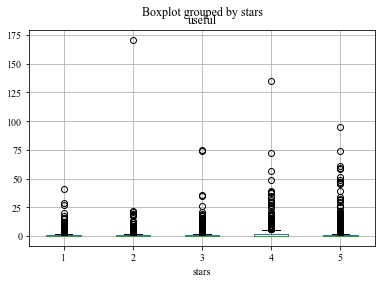

In [5]:
df.boxplot(column='useful', by='stars');

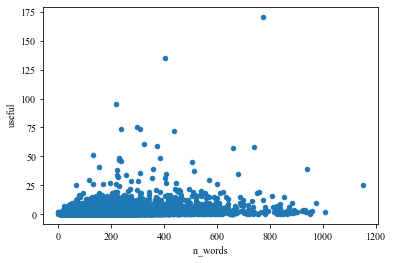

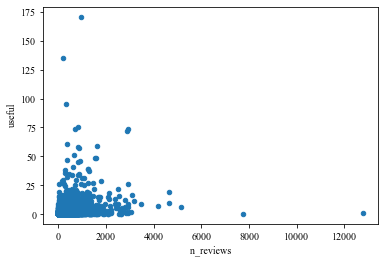

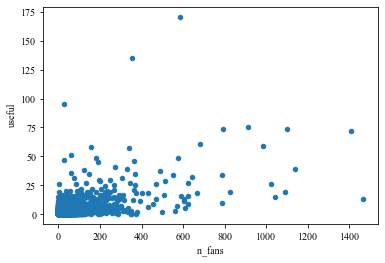

In [6]:
for x in ['n_words', 'n_reviews', 'n_fans']:
    df.plot.scatter(x=x, y='useful')

## Helper functions

In [7]:
def fit_treatment_group_models(model_name, models, X, Y, data_threshold = -1, verb=True):
    treatment_group_models = {}
    for tg in X.keys():
        x = X[tg]
        y = Y[tg]
        if data_threshold > 0 and len(x.index) < data_threshold:
            print('Too little data for treatment ' + str(tg))
            continue
        model = models[model_name]()
        try:
            model.fit(x, y)
        except Exception as e:
            if verb: 
                print(f'Model evaluation failed for treatment: {tg}')
                print('Caught exception: ')
                print(e)
            continue
        treatment_group_models[tg] = model
        if verb: print('Successfully fitted model for treatment ' + str(tg))
    return treatment_group_models

In [8]:
def calculate_pairwise_ate(fitted_models, X, is_classifier, verb=False):
    pairwise_treatments = list(itertools.combinations(fitted_models.keys(), 2))
    treatments = list(fitted_models.keys())
    n_treatments = len(treatments)
    ate_matrix = np.empty((n_treatments, n_treatments), dtype=object)
    for tg1, tg2 in pairwise_treatments:
        if verb: print('Comparing treatment groups ' + str(tg1) + ' and ' + str(tg2) + '.')
        
        m1 = fitted_models[tg1]
        m2 = fitted_models[tg2]
        
        i_tg1 = treatments.index(tg1)
        i_tg2 = treatments.index(tg2)
        
        for i in range(100):
            X_temp = resample(X, n_samples=int(0.5*len(X.index)))
        
            if is_classifier:
                m1_preds = m1.predict_proba(X_temp)
                m1_preds = m1_preds[:, 1]
                m2_preds = m2.predict_proba(X_temp)
                m2_preds = m2_preds[:, 1]
            else:
                m1_preds = m1.predict(X_temp)
                m2_preds = m2.predict(X_temp)
                
            ate12 = np.mean(m1_preds - m2_preds)
            ate21 = np.mean(m2_preds - m1_preds)
            
            if i == 0:
                ate_matrix[i_tg1, i_tg2] = [ate12]
                ate_matrix[i_tg2, i_tg1] = [ate21]
            else:
                ate_matrix[i_tg1, i_tg2].append(ate12)
                ate_matrix[i_tg2, i_tg1].append(ate21)
        
        if is_classifier:
            m1_preds = m1.predict_proba(X)
            m1_preds = m1_preds[:, 1]
            m2_preds = m2.predict_proba(X)
            m2_preds = m2_preds[:, 1]
        else:
            m1_preds = m1.predict(X)
            m2_preds = m2.predict(X)
        
        ate12 = np.mean(m1_preds - m2_preds)
        ate21 = np.mean(m2_preds - m1_preds)
        
        p_value = stats.ttest_ind(m1_preds, m2_preds)[1]  # Using the predictions from the last iteration

        if verb: 
            print('The ATE is ' + str(round(ate12, 2)) + '.')
            print('The ATE is ' + str(round(ate21, 2)) + '.')
            print('The p-value is ' + str(round(p_value, 3)) + '.')
    return ate_matrix, treatments, p_value

## Make causal inference

In [9]:
# Load data

data = Data(df, treatments, confounders_cont, confounders_cat)

# for key, value in data.X_test.items():
#     print(key)
#     print(len(value.index))

In [10]:
# Choose model(s) to evaluate

# models = {"linear_model": outcome_models.get_linear_model, 
#         "logistic_regression_model": outcome_models.get_logistic_regression_model,
#         "random_forest_model_1": outcome_models.get_random_forest_model_1,
#         "random_forest_model_2": outcome_models.get_random_forest_model_2}

models = {"logistic_regression_model": outcome_models.get_logistic_regression_model}

In [11]:
results = []

for model_name in models.keys():
    print('MODEL TO FIT: ' + model_name)
    print()    
    
    if model_name in ['linear_model']:
        X = data.X_test
        Y = data.Y_test
        is_classifier = False
    elif model_name in ['logistic_regression_model']:
        X = data.X_test_scaled
        Y = data.Y_test_discrete
        is_classifier = True
    elif model_name in ['random_forest_model_1', 'random_forest_model_2']:
        X = data.X_test
        Y = data.Y_test_discrete
        is_classifier = True
    else:
        raise NotImplementedError
    X_all = pd.concat(X.values(), ignore_index=True)
    
    fitted_models = fit_treatment_group_models(model_name, models, X, Y, data_threshold=400, verb=False)
    
    ate_matrix, treatments, p_value = calculate_pairwise_ate(fitted_models, X_all, is_classifier, verb=True)
    results.append((model_name, ate_matrix, treatments))
    
    print()
    print('-----')
    print()

MODEL TO FIT: logistic_regression_model

Too little data for treatment (0, 0, 1)
Too little data for treatment (0, 1, 1)
Too little data for treatment (1, 0, 1)
Too little data for treatment (1, 1, 1)
Comparing treatment groups (0, 0, 0) and (0, 1, 0).
The ATE is 0.02.
The ATE is -0.02.
The p-value is 0.0.
Comparing treatment groups (0, 0, 0) and (1, 0, 0).
The ATE is -0.13.
The ATE is 0.13.
The p-value is 0.0.
Comparing treatment groups (0, 0, 0) and (1, 1, 0).
The ATE is -0.04.
The ATE is 0.04.
The p-value is 0.0.
Comparing treatment groups (0, 1, 0) and (1, 0, 0).
The ATE is -0.14.
The ATE is 0.14.
The p-value is 0.0.
Comparing treatment groups (0, 1, 0) and (1, 1, 0).
The ATE is -0.06.
The ATE is 0.06.
The p-value is 0.0.
Comparing treatment groups (1, 0, 0) and (1, 1, 0).
The ATE is 0.08.
The ATE is -0.08.
The p-value is 0.0.

-----



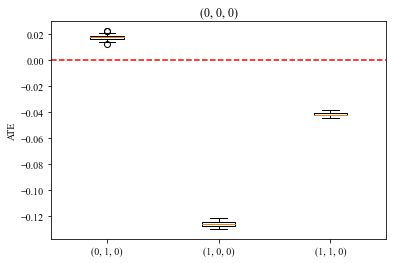

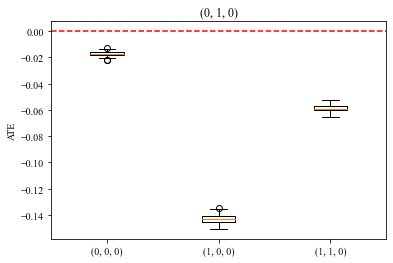

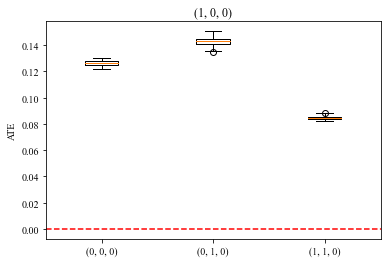

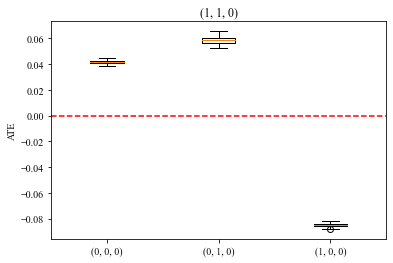

In [12]:
# Plot boxplots

for model_name, ate_matrix, treatments in results:
    for row in range(ate_matrix.shape[0]):
        temp = ate_matrix[row, :]
        i = np.argwhere(temp == None)[0][0]
        j = np.argwhere(temp != None).flatten()
        plt.figure()
        plt.title(str(treatments[i]))
        labels = [str(x) for i, x in enumerate(treatments) if i in j]
        plt.boxplot(tuple(temp[j]), labels=labels)
        plt.hlines(0, 0.5, 3.5, colors=['red'], linestyles='dashed')
        # plt.ylim((-0.2, 0.1))
        plt.ylabel('ATE')
        # plt.savefig(str(treatments[i]) + '.pdf')

# OLD

## Helper functions

In [ ]:
# Should we use all data or only the data that we have for each pair of groups?

def calculate_pairwise_ate(models, X):
    for tg1, tg2 in list(itertools.combinations(models.keys(), 2)):
        print('Comparing treatment groups ' + str(tg1) + ' and ' + str(tg2) + '.')
        m_1 = models[tg1]
        m_2 = models[tg2]

        x1 = X[tg1]
        x2 = X[tg2]

        x = pd.concat([x1, x2])

        ate = np.mean(m_1.predict(x) - m_2.predict(x))

        print('The ATE is ' + str(round(ate, 2)) + '.')

## Fit a regression model E[Y|T, X]

In [ ]:
def print_lm_info(lm, x_test, y_test):
    preds = lm.predict(x_test)
    
    # The coefficients
    print('Coefficients: \n', lm.coef_)

    # The mean squared error
    print('Mean squared error: %.2f'
          % mean_squared_error(y_test, preds))

    # The coefficient of determination
    print('R squared: %.2f'
          % r2_score(y_test, preds))

lm_models = {}

for tg in data.treatment_groups:
    print('Treatment group ' + str(tg))
    x = data.X_test[tg]
    y = data.Y_test[tg]
    if x is not None:
        lm = LinearRegression()
        lm.fit(x, y)
        lm_models[tg] = lm
        print_lm_info(lm, data.X_train[tg], data.Y_train[tg])  # Use train data (for sIBP) to evaluate fit
    else:
        print('There is no data available for this treatment grop.')
    print()

# Calculate the average treatment effect between pairwise treatment groups
calculate_pairwise_ate(lm_models, data.X_test)

## Fit a logistic model Pr[Y|T, X]

In [ ]:
clf_models = {}

for tg in data.treatment_groups:
    print('Treatment group ' + str(tg))
    x = data.X_test_scaled[tg]
    y = data.Y_test_discrete[tg]
    if x is not None:
        clf = LogisticRegression(max_iter=200)
        clf.fit(x, y)
        clf_models[tg] = clf
        # TODO: Evaluate fit
    else:
        print('There is no data available for this treatment grop.')
    print()

# Calculate the average treatment effect between pairwise treatment groups
calculate_pairwise_ate(clf_models, data.X_test_scaled)

## Fit a ZIP model 

In [ ]:
zip_models = {}

for tg in data.treatment_groups:
    print('Treatment group ' + str(tg))
    x = data.X_test_scaled[tg]
    y = data.Y_test[tg]
    if x is not None:
        zip_model = sm.ZeroInflatedPoisson(endog=y, exog=x, exog_infl=x, inflation='logit').fit(maxiter=200)
        # print(zip_model.summary())
        zip_models[tg] = zip_model
        # TODO: Evaluate fit
    else:
        print('There is no data available for this treatment grop.')
    print()

In [ ]:
# Calculate the average treatment effect between pairwise treatment groups

# calculate_pairwise_ate(zip_models, data.X_test_scaled)

for tg1, tg2 in list(itertools.combinations(zip_models.keys(), 2)):
    print('Comparing treatment groups ' + str(tg1) + ' and ' + str(tg2) + '.')
    m_1 = zip_models[tg1]
    m_2 = zip_models[tg2]

    x1 = data.X_test_scaled[tg1]
    x2 = data.X_test_scaled[tg2]

    x = pd.concat([x1, x2])
    
    ate = np.mean(m_1.predict(x, exog_infl=x) - m_2.predict(x, exog_infl=x))

    print('The ATE is ' + str(round(ate, 2)) + '.')